In [3]:
import pandas as pd
import typing
import seaborn as sns
from matplotlib import pyplot as plt
import tensorflow as tf
import numpy as np
import scipy.stats as stats


In [28]:
df = pd.read_csv('data/load_data/Electricity_Profile.csv', sep=",", header=None)
df = df.rename(columns={0: 'load'})
df['time'] = df.index%2400
freq_minutes = 1
n_rows = len(df)
date_col = pd.date_range(start='2023-01-01', periods=n_rows, freq=f'{freq_minutes}min')
df['datetime'] = date_col
df.set_index('datetime', inplace=True)
df

,load,time
datetime,,
2023-01-01 00:00:00,200,0
2023-01-01 00:01:00,200,1
2023-01-01 00:02:00,200,2
2023-01-01 00:03:00,91,3
2023-01-01 00:04:00,91,4
...,...,...
2023-04-10 23:55:00,91,2395
2023-04-10 23:56:00,91,2396
2023-04-10 23:57:00,91,2397


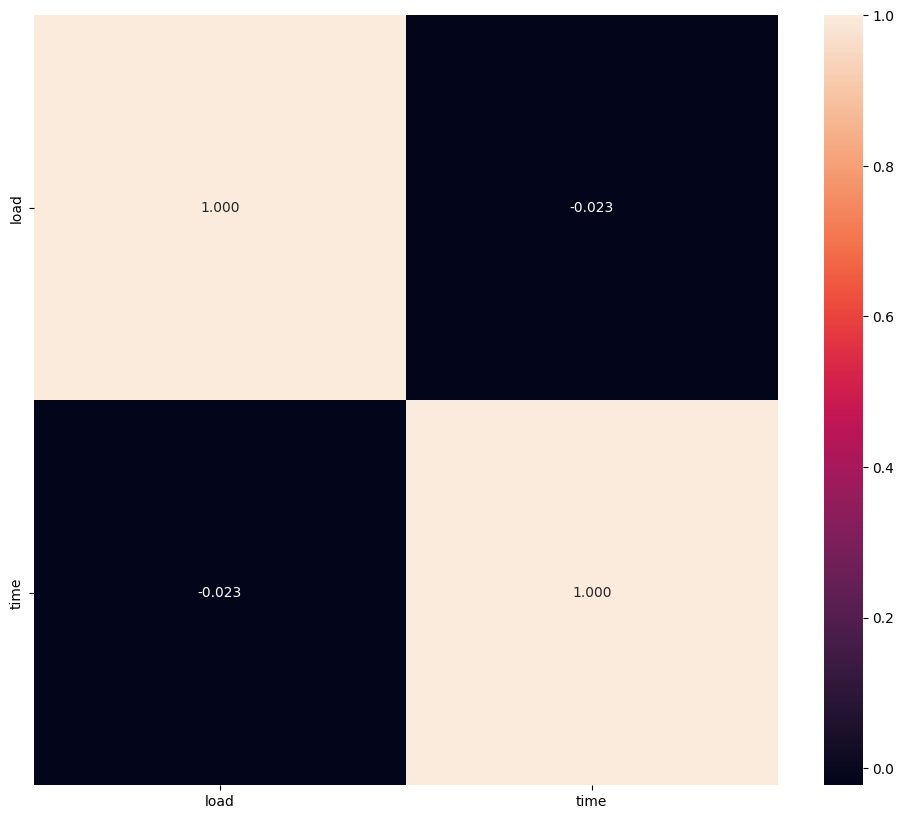

In [5]:
corrMatrix = df.corr(numeric_only=True)
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corrMatrix, annot= True, ax=ax, fmt='.3f')
plt.show()

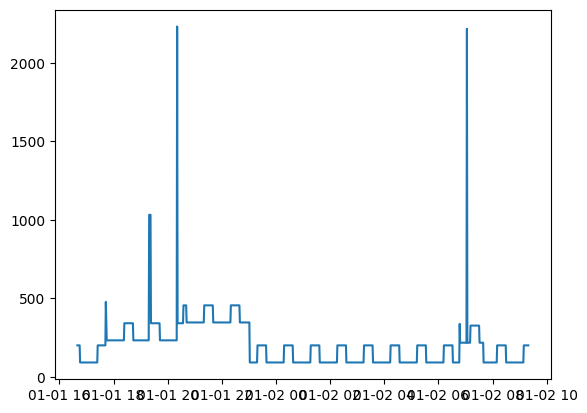

In [6]:
# Plot the time series
start = 1000
end = 2000
plt.plot( df.iloc[start:end].index, df['load'].iloc[start:end])
plt.show()

In [7]:
from sklearn.feature_selection import SelectKBest
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import RidgeCV
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_validate
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_absolute_error
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score, mean_absolute_percentage_error
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection  import RandomizedSearchCV

In [6]:
Y = df["load"].to_numpy()
# feature matrix
X = df["time"].to_numpy().reshape(-1,1)

In [72]:
Y = df["load"].to_numpy()
# feature matrix
X = df["time"].to_numpy().reshape(-1,1)

def create_forest_model():
    forestModel = make_pipeline(
        SelectKBest(k="all"),
        StandardScaler(),
        RandomForestRegressor(
            n_estimators=100,
            max_depth=50,
            random_state=77,
            n_jobs=-1
        )
    )
    return forestModel

tscv = TimeSeriesSplit()
all_splits = list(tscv.split(X, Y))
for (train, test) in all_splits:
    X_train, X_test = X[train], X[test]
    Y_train, Y_test = Y[train], Y[test]

    forestModel = create_forest_model()
    y_train = Y_train
    y_test = Y_test

    forestModel.fit(X_train, y_train)
    print('Random Forest Regressor Model Training MAE:', round(mean_absolute_error(y_train, forestModel.predict(X_train)),5))
    y_pred = forestModel.predict(X_test)
    print('Random Forest Regressor Mode Test MAE:', round(mean_absolute_error(y_test, forestModel.predict(X_test)),5))
    mape = mean_absolute_percentage_error(y_pred, y_test)
    print("Prediction accuracy for ", 100-np.mean(mape))
    
    print("Other Test metrics: ")
    mae = mean_absolute_error(y_test, y_pred)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)

    print("MAE:", mae)
    print("MSE:", mse)
    print("RMSE:", rmse)
    print("R2 score:", r2)
    print("\n")
        

Random Forest Regressor Model Training MAE: 123.08858
Random Forest Regressor Mode Test MAE: 129.28518
Prediction accuracy for  99.39293063486141
Other Test metrics: 
MAE: 129.28518063482335
MSE: 78970.87858417637
RMSE: 281.01757700218036
R2 score: -0.06613986634931068


Random Forest Regressor Model Training MAE: 122.70199
Random Forest Regressor Mode Test MAE: 142.66442
Prediction accuracy for  99.3419191373583
Other Test metrics: 
MAE: 142.66441906404555
MSE: 111257.70059637273
RMSE: 333.55314508541625
R2 score: 0.00034295877085543935


Random Forest Regressor Model Training MAE: 130.75603
Random Forest Regressor Mode Test MAE: 131.72154
Prediction accuracy for  99.40527555354794
Other Test metrics: 
MAE: 131.72154374420447
MSE: 82632.18675748934
RMSE: 287.458147836323
R2 score: -0.04385011365310487


Random Forest Regressor Model Training MAE: 128.07904
Random Forest Regressor Mode Test MAE: 121.91602
Prediction accuracy for  99.43973421976742
Other Test metrics: 
MAE: 121.91602467

Random Forest best Regressor Model  Training MAE: 124.35456
Random Forest best Regressor Model  Test MAE: 120.07294
Prediction accuracy for  99.45544703527983
Other Test metrics: 
MAE: 120.07294044656253
MSE: 62080.76020547098
RMSE: 249.16010957910373
R2 score: 0.02143400653783356




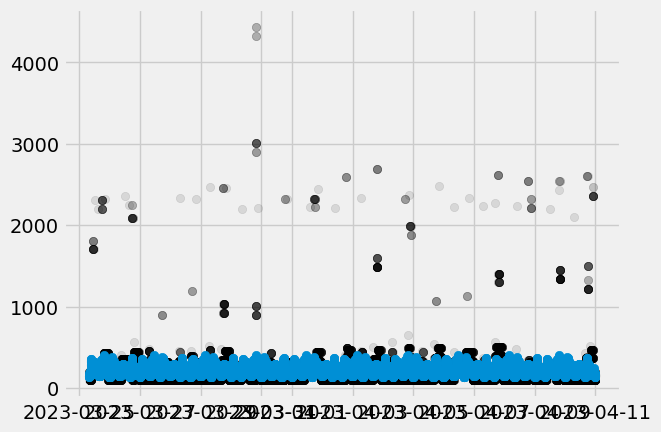

In [75]:

tscv = TimeSeriesSplit()
all_splits = list(tscv.split(X, Y))
(train, test) = all_splits[-1]
X_train, X_test = X[train], X[test]
Y_train, Y_test = Y[train], Y[test]


forestModel = create_forest_model()
y_train = Y_train
y_test = Y_test

params = {
    'selectkbest__k':  range(1, X_train.shape[1] + 1),
    'randomforestregressor__n_estimators': [50, 100, 150, 200],
    'randomforestregressor__max_depth': [10, 20, 30, 40, 50, 60,70]
}
rs = RandomizedSearchCV(forestModel,
                    param_distributions=params,
                    n_iter=10,
                    n_jobs=-1,
                    cv=10
                    )


rs.fit(X_train, y_train)
best_model = rs.best_estimator_

print('Random Forest best Regressor Model  Training MAE:', round(mean_absolute_error(y_train, best_model.predict(X_train)),5))
y_pred = best_model.predict(X_test)
print('Random Forest best Regressor Model  Test MAE:', round(mean_absolute_error(y_test, best_model.predict(X_test)),5))
mape = mean_absolute_percentage_error(y_pred, y_test)
print("Prediction accuracy for ", 100-np.mean(mape))
plt.figure()
plt.scatter(df.index[test], y_test, alpha = 0.1, color='black')
# Plot the data and label it according to the SVM
plt.scatter(df.index[test], y_pred)

print("Other Test metrics: ")
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
r2 = r2_score(y_test, y_pred)

print("MAE:", mae)
print("MSE:", mse)
print("RMSE:", rmse)
print("R2 score:", r2)
print("\n")



its good at prediciting general trends but not

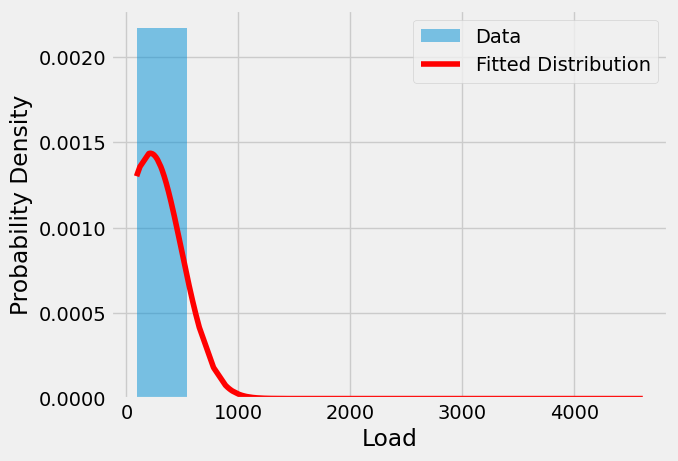

In [90]:
fit_params = stats.norm.fit(df['load'])

# Generate values from the fitted distribution
x = stats.norm(*fit_params).rvs(len(df))

# Plot the histogram of the data
plt.hist(df['load'], bins=10, density=True, alpha=0.5, label='Data')

# Plot the probability density function (PDF) of the fitted distribution
plt.plot(sorted(df['load']), stats.norm.pdf(sorted(df['load']), *fit_params), 'r-', label='Fitted Distribution')

# Add labels and a legend
plt.xlabel('Load')
plt.ylabel('Probability Density')
plt.legend()

# Show the plot
plt.show()

SVM regressor

In [8]:
from sklearn.svm import SVR
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
import matplotlib.pyplot as plt

In [29]:
df = df[::30]
df

,load,time
datetime,,
2023-01-01 00:00:00,200,0
2023-01-01 00:30:00,91,30
2023-01-01 01:00:00,200,60
2023-01-01 01:30:00,91,90
2023-01-01 02:00:00,200,120
...,...,...
2023-04-10 21:30:00,361,2250
2023-04-10 22:00:00,2361,2280
2023-04-10 22:30:00,91,2310


2399 (4800, 2)


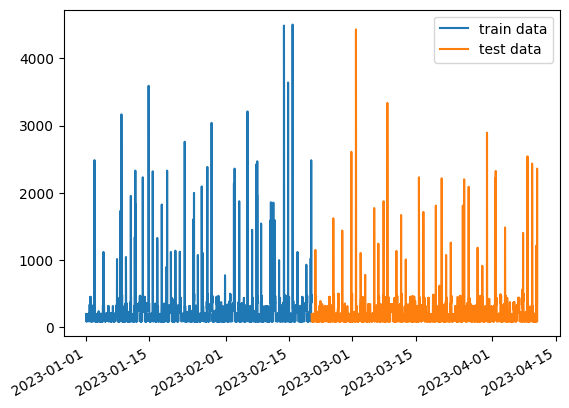

In [31]:
training_size = 4800//2-1
print(training_size, df.shape)
train_data = df.iloc[:training_size]
val_data = df.iloc[training_size:training_size+training_size]
plt.plot(train_data.index, train_data[['load']], label = 'train data')
plt.plot(val_data.index, val_data[['load']], label='test data')
plt.legend()
plt.gcf().autofmt_xdate()

In [32]:
train_features, train_labels  = train_data.drop("load",axis=1), train_data[["load"]]
test_features, test_labels = val_data.drop("load",axis=1), val_data[["load"]]
print(train_features.shape, train_labels.shape)
print(test_features.shape, test_labels.shape)

(2399, 1) (2399, 1)
(2399, 1) (2399, 1)


d:\mukul\anaconda3\envs\SOML\lib\site-packages\sklearn\utils\validation.py:1143: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Results for C=1:
MAPE for max 0.5417787247742664


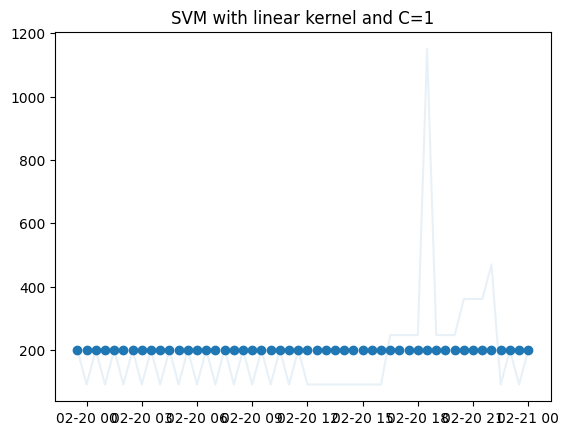

In [33]:

X_train, X_test = train_features, test_features
y_train, y_test = train_labels, test_labels
C = 1
clf = SVR(kernel='poly', C=C)
# Train the SVM on the training data
clf.fit(X_train, y_train)
# Use the SVM on the test data
y_pred = clf.predict(X_test)

# Print the results for this C value
print(f"Results for C={C}:")
mape = mean_absolute_percentage_error(y_pred, y_test)
print("MAPE for max", np.mean(mape))
# Plot the SVM
plt.figure()
plt.title(f"SVM with linear kernel and C={C}")
# Plot the actual results to compare to (faded)
plt.plot(val_data.index[:50], val_data[['load']][:50], label='test data', alpha=0.1)
# Plot the data and label it according to the SVM
plt.scatter(val_data.index[:50], y_pred[:50])